In [ ]:
# Colab setup

# from google.colab import drive
# drive.mount("/content/drive/")

# %cd "/content/drive/MyDrive/PACS/APSC_project/bayesian_network/examples/3_autoencoder"

# try:
#     from dlroms import *
# except:
#     !pip install git+https://github.com/NicolaRFranco/dlroms.git
#     from dlroms import *

In [ ]:
# Import libraries

import numpy as np
from dlroms import *
from dlroms.dnns import *
import matplotlib.pyplot as plt
import torch
from dolfin import *
import time

In [ ]:
# Setup

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.manual_seed(0) # TODO: change seed initialization

class Args:
	def __init__(self, n_snapshots_high, n_snapshots_low, input_dir, output_dir, checkpoint_dir, verbose):
		self.n_snapshots_high = n_snapshots_high
		self.n_snapshots_low = n_snapshots_low
		self.input_dir = input_dir
		self.output_dir = output_dir
		self.checkpoint_dir = checkpoint_dir
		self.verbose = verbose

args = Args(75, 600, 'snapshots', 'outputs', 'checkpoints', True)

In [ ]:
# Domain and mesh definition

mesh_H = fe.unitsquaremesh(100, 100) # fine mesh
V_H = fe.space(mesh_H, 'CG', 1) 
Nh_H = V_H.dim()

mesh_C = fe.unitsquaremesh(50, 50) # coarse mesh
V_C = fe.space(mesh_C, 'CG', 1)
Nh_C = V_C.dim()

In [ ]:
# Load snapshots

path_train_H = os.path.join(args.input_dir, 'snapshots_train_H_' + str(args.n_snapshots_high) + '.npz')
if not os.path.exists(path_train_H):
	print(f"High-fidelity training snapshots not found at {path_train_H}.")
	exit()
data_train_H = np.load(path_train_H)
N_train_H = data_train_H['mu'].shape[0]
mu_train_H, u_train_H = data_train_H['mu'].astype(np.float32), data_train_H['u'].astype(np.float32)
mu_train_H, u_train_H = torch.tensor(mu_train_H).to(device), torch.tensor(u_train_H).to(device)

path_train_C = os.path.join(args.input_dir, 'snapshots_train_C_' + str(args.n_snapshots_low) + '.npz')
if not os.path.exists(path_train_C):
	print(f"Low-fidelity training snapshots not found at {path_train_C}.")
	exit()
data_train_C = np.load(path_train_C)
N_train_C = data_train_C['mu'].shape[0]
mu_train_C, u_train_C = data_train_C['mu'].astype(np.float32), data_train_C['u'].astype(np.float32)
mu_train_C, u_train_C = torch.tensor(mu_train_C).to(device), torch.tensor(u_train_C).to(device)

path_test = os.path.join(args.input_dir, 'snapshots_test.npz')
if not os.path.exists(path_test):
	print(f"Test snapshots not found at {path_test}.")
	exit()
data_test = np.load(path_test)
N_test = data_test['mu'].shape[0]
mu_test, u_test = data_test['mu'].astype(np.float32), data_test['u'].astype(np.float32)
mu_test, u_test = torch.tensor(mu_test).to(device), torch.tensor(u_test).to(device)

In [ ]:
# Traning architecture

m = 16
k = 4

# torch.set_default_dtype(torch.float32)

# The low-fidelity autoencoder has 1/3 dofs of the high-fidelity one

psi_prime = Dense(Nh_C, 4, activation=None)

psi = Dense(4, 100 * m) + \
		Reshape(4 * m, 5, 5) + \
		Deconv2D(7, (4 * m, 2 * m), 1) + \
		Deconv2D(4, (2 * m, m), 2) + \
		Deconv2D(5, (m, 1), 2, activation=None) + \
		Reshape(-1)

phi = Dense(4, 50 * k) + \
		Dense(50 * k, 50 * k) + \
		Dense(50 * k, 4, activation=None)

chi = Local(V_C, V_H, support=0.1, activation=None) # change the support?

print("Trainable parameters:")
print(" Encoder:", psi_prime.dof())
print(" Decoder:", psi.dof())
print(" Dense NN:", phi.dof())
print(" Mesh-informed layer:", chi.dof())

Trainable parameters:
 Encoder: 10408
 Decoder: 116993
 Dense NN: 42004
 Mesh-informed layer: 745414


In [ ]:
# Train the autoencoder (nonlinear dimensionality reduction) on the low-fidelity dataset

autoencoder = DFNN(psi_prime, psi) # encoder + decoder
autoencoder.He()

if device.type == 'cuda':
	autoencoder.cuda()
else:
	autoencoder.cpu()

autoencoder.train(u_train_C, u_train_C, ntrain=N_train_C, epochs=200, loss=mre(euclidean), verbose=True)

		Train		Test
Epoch 200:	3.94e-02	nan.

>> ETA: 2.28s.

Training complete. Elapsed time: 7 minutes 36.54 seconds.


In [ ]:
# Use the trained encoder to generate the reduced-order version of the low-fidelity dataset

# autoencoder.freeze()

psi_prime.eval()

with torch.no_grad():
  u_train_C_ro = psi_prime(u_train_C)

In [ ]:
# Use the reduced-order low-fidelity dataset to train the dense NN mapping the parameters to the reduced-order low-fidelity solution

dense = DFNN(phi)
dense.He()

if device.type == 'cuda':
	dense.cuda()
else:
	dense.cpu()

dense.train(mu_train_C, u_train_C_ro, ntrain=N_train_C, epochs=200, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 200:	2.72e-02	nan.

>> ETA: 0.30s.

Training complete. Elapsed time: 1 minutes 0.62 seconds.


In [ ]:
# Freeze the dense NN and the decoder

phi.freeze()
psi.freeze() # psi is already frozen since autoencoder.freeze()?

In [ ]:
# Train the multi-fidelity model

chi.He() # change initialization for chi?

model = DFNN(phi, psi, chi)

if device.type == 'cuda':
	model.cuda()
else:
	model.cpu()

model.train(mu_train_H, u_train_H, ntrain=N_train_H, epochs=40, loss=mse(euclidean), verbose=True)

		Train		Test
Epoch 40:	1.08e-01	nan.

>> ETA: 0.71s.

Training complete. Elapsed time: 28.30 seconds.


In [ ]:
# Use the final model to predict the high-fidelity solution

model.eval()

with torch.no_grad():
  u_train_H_pred = model(mu_train_H)

In [ ]:
# Compute the relative error

error_train = torch.norm(u_train_H - u_train_H_pred, dim=1) / torch.norm(u_train_H, dim=1)
print('Relative training error: {:.2f}%'.format(100 * torch.mean(error_train)))

Relative training error: 3.77%


In [ ]:
# Relative training error (75, 600): 4.37%
# Relative training error (75, 1200): 3.22%
# Relative training error (150, 2400): 3.33%
# Relative training error (150, 4800): 3.32%
# Relative training error (300, 4800): 3.77%

In [ ]:
# Apply the model to the test set

with torch.no_grad():
  u_test_pred = model(mu_test)

error_test = torch.norm(u_test - u_test_pred, dim=1) / torch.norm(u_test, dim=1)
print('Relative test error: {:.2f}%'.format(100 * torch.mean(error_test)))

Relative test error: 3.98%


In [ ]:
# Relative test error (75, 600): 6.59%
# Relative test error (75, 1200): 5.29%
# Relative test error (150, 2400): 4.28%
# Relative test error (150, 4800): 4.21%
# Relative test error (300, 4800): 3.98%

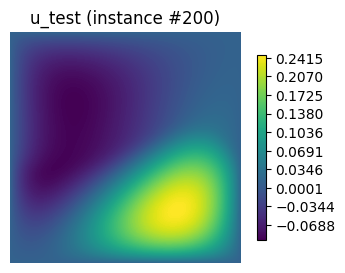

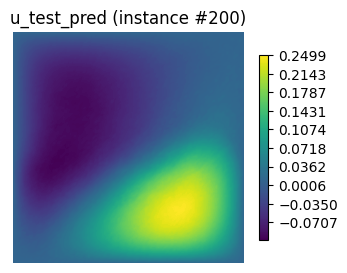

In [ ]:
# Plot some results

index = 200

plt.figure(figsize=(4, 3))
fe.plot(u_test[index, :], V_H, colorbar=True)
plt.title('u_test (instance #' + str(index) + ')')

plt.figure(figsize=(4, 3))
fe.plot(u_test_pred[index, :], V_H, colorbar=True)
plt.title('u_test_pred (instance #' + str(index) + ')')

plt.show()

In [ ]:
# Save encoder, decoder, dense NN, and mesh-informed layer

psi_prime.save(os.path.join(args.checkpoint_dir, 'psi_prime_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))
psi.save(os.path.join(args.checkpoint_dir, 'psi_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))
phi.save(os.path.join(args.checkpoint_dir, 'phi_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))
chi.save(os.path.join(args.checkpoint_dir, 'chi_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))

# torch.save(psi_prime.state_dict(), os.path.join(args.checkpoint_dir, 'psi_prime_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))
# torch.save(psi.state_dict(), os.path.join(args.checkpoint_dir, 'psi_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))
# torch.save(phi.state_dict(), os.path.join(args.checkpoint_dir, 'phi_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))
# torch.save(chi.state_dict(), os.path.join(args.checkpoint_dir, 'chi_' + str(args.n_snapshots_low) + '_' + str(args.n_snapshots_high)))